In [180]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import pandas as pd


def scanpath(saccades:pd.DataFrame, fixations:pd.DataFrame, tmin:float, tmax:float, samples:pd.DataFrame=None, img_path:str=None, 
             screen_res_x:int=1920, screen_res_y:int=1080, img_res_x:int=1280, img_res_y:int=1024):
    
    # Filter saccades, fixations and samples to defined time interval
    saccades_t = saccades.loc[(saccades['tStart'] >= tmin) & (saccades['tStart'] <= tmax)]
    fixations_t = fixations.loc[(fixations['tStart'] >= tmin) & (fixations['tStart'] <= tmax)]
    if type(samples) == pd.DataFrame:
        samples_t = samples.loc[(samples['tSample'] >= tmin) & (samples['tSample'] <= tmax)]

    
    # Define figure and axes    
    if type(samples) == pd.DataFrame:
        fig, axs = plt.subplots(nrows=2, ncols=1)
        ax_main = axs[0]
        ax_gaze = axs[1]
    else:
        fig, ax_main = plt.subplots()
    
    fig.suptitle(f'Scanpath tmin:{tmin} - tmax:{tmax}')

    # Remove ticks
    ax_main.set_xticks([])
    ax_main.set_yticks([])

    # Plot image if provided
    if img_path != None:
        # Load search image
        img = mpimg.imread(img_path)
        ax_main.imshow(img, zorder=0)

        print(img.shape)

    # Plot fixations as dots if any in time interval
    if len(fixations_t):
        # Colormap: Get fixation durations for scatter circle size
        sizes = fixations_t['duration']
        # Define rainwbow cmap for fixations
        cmap = plt.cm.rainbow
        # Define the bins and normalize
        fix_num = fixations_t.index + 1
        bounds = np.linspace(1, fix_num[-1] + 1, fix_num[-1] + 1)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        ax_main.scatter(fixations_t['xAvg'] - (screen_res_x - img_res_x) / 2,
                    fixations_t['yAvg'] - (screen_res_y - img_res_y) / 2,
                    c=fix_num, s=sizes, cmap=cmap, norm=norm, zorder=2)
    
        # Colorbar
        PCM = ax_main.get_children()[1]  # When the fixations dots for color mappable were ploted (first)
        cb = plt.colorbar(PCM, ax=ax_main, ticks=[fix_num[0] + 1/2, fix_num[int(len(fix_num)/2)]+1/2, fix_num[-1]+1/2])
        cb.ax.set_yticklabels([fix_num[0], fix_num[int(len(fix_num)/2)], fix_num[-1]])
        cb.set_label('# of fixation')

    # Plot scanpath and gaze if samples provided
    if type(samples) == pd.DataFrame:

        # Scanpath
        ax_main.plot(samples_t['LX'] - (1920 - 1280) / 2, samples_t['LY'] - (1080 - 1024) / 2, '--', color='C0', zorder=1)
        ax_main.plot(samples_t['RX'] - (1920 - 1280) / 2, samples_t['RY'] - (1080 - 1024) / 2, '--', color='black', zorder=1)
        
        # Gaze
        ax_gaze.plot(samples_t['tSample'], samples_t['LX'], label='Left X')
        ax_gaze.plot(samples_t['tSample'], samples_t['LY'], label='Left Y')
        ax_gaze.plot(samples_t['tSample'], samples_t['RX'], label='Right X')
        ax_gaze.plot(samples_t['tSample'], samples_t['RY'], label='Right Y')

        plot_min, plot_max = ax_gaze.get_ylim()

        for _, saccade in saccades_t.iterrows():
            ax_gaze.vlines(x=saccade['tStart'], ymin=plot_min, ymax=plot_max, colors='red', linestyles='--', label='sac')

        for fix_idx, fixation in fixations_t.iterrows():
            color = cmap(norm(fix_idx + 1))
            ax_gaze.axvspan(ymin=0, ymax=1, xmin=fixation['tStart'], xmax=fixation['tStart'] + fixation['duration'], color=color, alpha=0.4, label='fix')

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=8)
        ax_gaze.set_ylabel('Gaze')
        ax_gaze.set_xlabel('Time [s]')

    

(1024, 1280, 3)


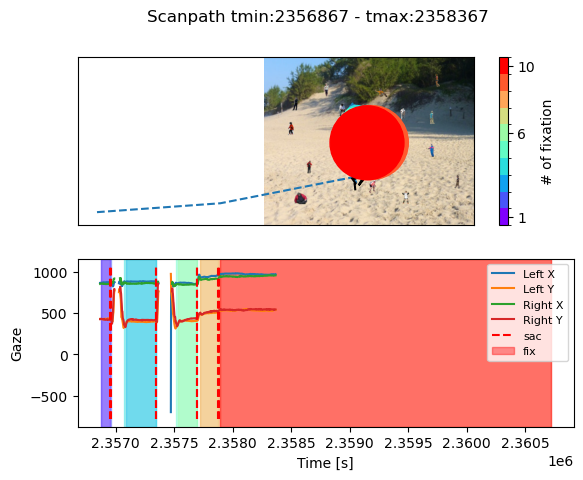

In [181]:
# ----- Example -----#
import os
import pandas as pd

# Get path to samples from parsed edf
cwd = os.getcwd()
parent_directory = os.path.abspath(os.path.join(cwd, os.pardir))
path_to_saccades = parent_directory + '/example_dataset_derivatives/sub-ab01/ses-second/sacc.hdf5'
path_to_fixations = parent_directory + '/example_dataset_derivatives/sub-ab01/ses-second/fix.hdf5'
path_to_samples = parent_directory + '/example_dataset_derivatives/sub-ab01/ses-second/samples.hdf5'

# Load samples.hdf5 file
saccades = pd.read_hdf(path_or_buf=path_to_saccades)
fixations = pd.read_hdf(path_or_buf=path_to_fixations)
samples = pd.read_hdf(path_or_buf=path_to_samples)

# Plot Scanpath
scanpath(saccades=saccades, fixations=fixations, tmin=samples['tSample'][0], tmax=samples['tSample'][1500], samples=samples, img_path='test_img.jpg')